# Análisis Exploratorio - EMA (2018 - 2024)
## 1. Concatenación de las variables en un dataset maestro

In [ ]:
import pandas as pd
import os

In [ ]:
data_path = "../data/raw/"
variables = ['HR', 'pp', 'press', 'radinf', 'tempsup', 'vel', 'dir']
lista_dfs = []

In [35]:
for var in variables:
    nombre_archivo = f'{var}_hourly_2018_2025.csv'
    archivo = os.path.join(data_path, nombre_archivo)
    
    if os.path.exists(archivo):
            # 1. Cargar datos
            df_temp = pd.read_csv(archivo, header=[0, 1], index_col=0)
            
            # 2. Limpieza de nombres de columnas (quita espacios extraños)
            df_temp.columns = df_temp.columns.map(lambda x: (str(x[0]).strip(), str(x[1]).strip()))
            
            # 3. Lógica Condicional: 'sum' para lluvia, 'mean' para el resto
            metrica = 'sum' if var == 'pp' else 'mean'
                
            try:
                df_selected = df_temp.xs(metrica, level=1, axis=1)
                df_selected.columns = [var]
                
                # --- CORRECCIÓN DE ÍNDICE ---
                # Convertimos el índice a datetime AQUÍ
                # errors='coerce' pondrá NaT si encuentra la palabra "time" u otra basura
                df_selected.index = pd.to_datetime(df_selected.index, errors='coerce')
                
                # Eliminamos filas donde el índice sea NaT (basura del header repetido)
                df_selected = df_selected[df_selected.index.notnull()]
                
                lista_dfs.append(df_selected)
                print(f"{var}: Cargado. Índice empieza en: {df_selected.index[0]}")
                
            except KeyError:
                print(f" Error en {var}")

HR: Cargado. Índice empieza en: 2018-01-01 00:00:00
pp: Cargado. Índice empieza en: 2018-01-01 00:00:00
press: Cargado. Índice empieza en: 2018-01-01 00:00:00
radinf: Cargado. Índice empieza en: 2018-01-01 00:00:00
tempsup: Cargado. Índice empieza en: 2018-01-01 00:00:00
vel: Cargado. Índice empieza en: 2018-01-01 00:00:00
dir: Cargado. Índice empieza en: 2018-01-01 00:00:00


In [41]:
# CONCATENAR
df_master = pd.concat(lista_dfs, axis=1)

In [ ]:
# Se queda con la primera aparición y borra las siguientes
# Evita duplicados en columnas
df_master = df_master.loc[:, ~df_master.columns.duplicated()]

print(f"Dimensiones tras eliminar duplicados: {df_master.shape}")

Dimensiones tras eliminar duplicados: (67200, 7)


## 2. Calidad y Limpieza de Datos

In [43]:
# 1. Conteo de nulos por variable
print("--- Valores Nulos por Variable ---")
nulos = df_master.isnull().sum()
print(nulos)

print("\n--- Porcentaje de Nulos ---")
print((nulos / len(df_master)) * 100)

--- Valores Nulos por Variable ---
HR         548
pp           0
press      548
radinf     548
tempsup    548
vel        548
dir        548
dtype: int64

--- Porcentaje de Nulos ---
HR         0.815476
pp         0.000000
press      0.815476
radinf     0.815476
tempsup    0.815476
vel        0.815476
dir        0.815476
dtype: float64


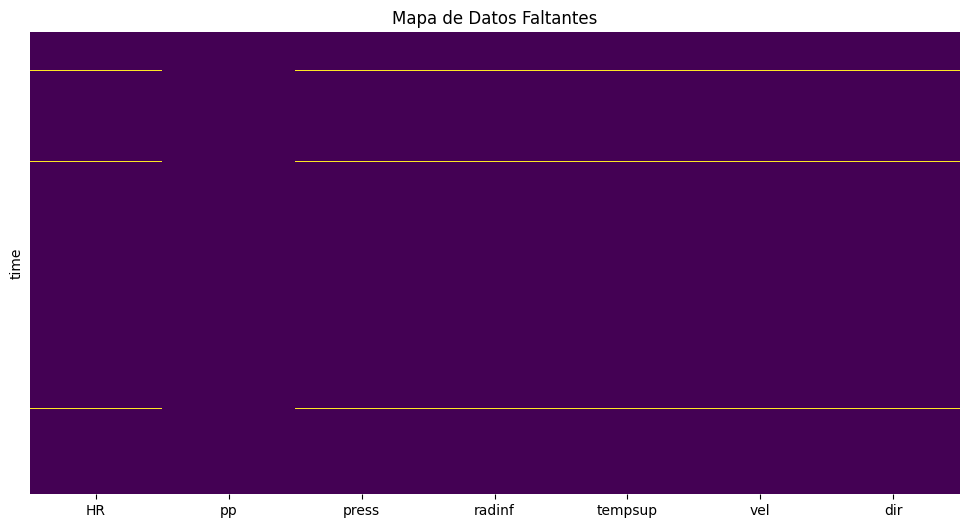

In [44]:
# 2. Visualización de los huecos (Mapa de Calor de Nulos)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# Isnull devuelve True (1) si falta dato, False (0) si está bien.
# El mapa mostrará rayas blancas donde falten datos.
sns.heatmap(df_master.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa de Datos Faltantes")
plt.show()

In [45]:
# 2. Creación de df_clean e Imputación
# Usamos interpolación por tiempo.
# Al ser variables físicas continuas (temp, presión), si a la 1:00 vale 10 y a las 3:00 vale 20,
# asumiremos que a las 2:00 valía 15.
df_clean = df_master.interpolate(method='time', limit_direction='both')

# 3. Verificación Final (Debe dar todo 0)
print("\n--- Nulos restantes en df_clean ---")
print(df_clean.isnull().sum())


--- Nulos restantes en df_clean ---
HR         0
pp         0
press      0
radinf     0
tempsup    0
vel        0
dir        0
dtype: int64


In [ ]:
# Guardar el DataFrame limpio
output_path = "../data/processed/"
df_clean.to_csv(output_path + "df_master.csv", index=False)

## 3. Ingeniería de Características

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
#1. Transformación matemática
# Pasamos de Grados a Radianes
wd_rad = df_clean['dir'] * np.pi / 180

# Calculamos los componentes vectoriales
df_clean['dir_sin'] = np.sin(wd_rad)
df_clean['dir_cos'] = np.cos(wd_rad)

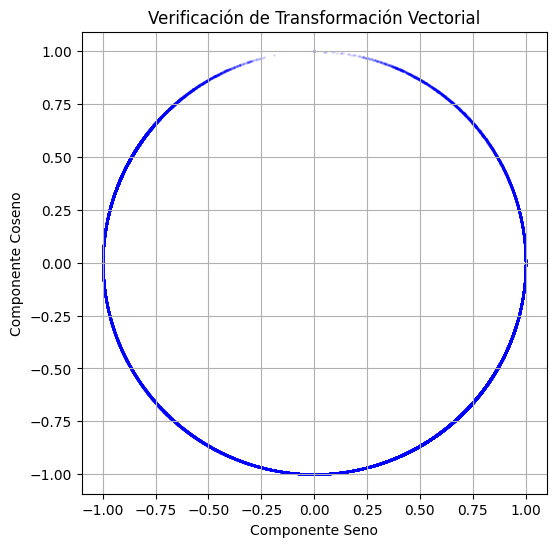

In [50]:
# 2. Verificación visual
plt.figure(figsize=(6, 6))
plt.scatter(df_clean['dir_sin'], df_clean['dir_cos'], alpha=0.1, s=1, c='blue')
plt.title("Verificación de Transformación Vectorial")
plt.xlabel("Componente Seno")
plt.ylabel("Componente Coseno")
plt.grid(True)
plt.axis('equal')
plt.show()

In [51]:
# 3. Revisión de datos
print(df_clean[['dir', 'dir_sin', 'dir_cos']].head())

                         dir   dir_sin   dir_cos
time                                            
2018-01-01 00:00:00  145.642  0.564362 -0.825527
2018-01-01 01:00:00  284.018 -0.970220  0.242227
2018-01-01 02:00:00   63.065  0.891521  0.452979
2018-01-01 03:00:00   34.775  0.570355  0.821398
2018-01-01 04:00:00   72.418  0.953286  0.302070


## 4. Análisis de Correlación

In [21]:
import seaborn as sns

In [52]:
# 1. Calculamos la matriz de correlación
# Excluimos la columna 'dir' original (en grados) porque ya tenemos sus vectores
# y los grados crudos ensucian la correlación lineal.
cols_to_analyze = [c for c in df_clean.columns if c != 'dir']
corr_matrix = df_clean[cols_to_analyze].corr()

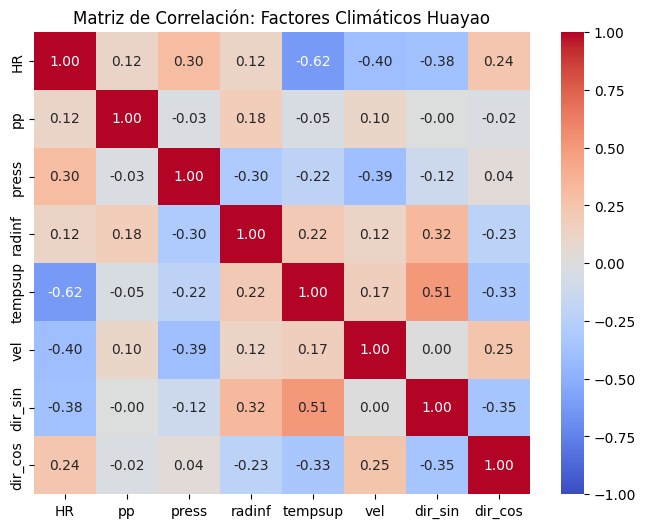

In [53]:
# 2. Visualización (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlación: Factores Climáticos Huayao")
plt.show()

In [54]:
# 3. Ranking de influencia sobre la Temperatura
# Esto nos dice qué variables son los mejores predictores de la temperatura superficial
print("--- Correlación con la Temperatura Superficial (tempsup) ---")
print(corr_matrix['tempsup'].sort_values(ascending=False))

--- Correlación con la Temperatura Superficial (tempsup) ---
tempsup    1.000000
dir_sin    0.506540
radinf     0.215853
vel        0.165806
pp        -0.045927
press     -0.217070
dir_cos   -0.328701
HR        -0.623758
Name: tempsup, dtype: float64


### 4.1 Filtrado para Rango Horario Estratégico

In [58]:
# 1. Filtrado Estratégico (Cruce de medianoche)
# between_time maneja automáticamente el rango que cruza las 00:00 h
df_night = df_clean.between_time('18:00', '07:00')

print(f"--- REPORTE DE FILTRADO ---")
print(f"Total de datos: {len(df_clean)}")
print(f"Datos nocturnos (Zona de Helada): {len(df_night)}")
print(f"Retención: {len(df_night)/len(df_clean):.1%}")

--- REPORTE DE FILTRADO ---
Total de datos: 67200
Datos nocturnos (Zona de Helada): 39200
Retención: 58.3%


In [32]:
print("--- 1. Diagnóstico del Índice ---")
print(f"Tipo de Índice actual: {type(df_clean.index)}")
print(f"Dtype del Índice: {df_clean.index.dtype}")
print(f"Muestra del índice: {df_clean.index[0]}")

df_clean.index = pd.to_datetime(df_clean.index, errors='coerce')

--- 1. Diagnóstico del Índice ---
Tipo de Índice actual: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Dtype del Índice: datetime64[ns]
Muestra del índice: 1970-01-01 00:00:00


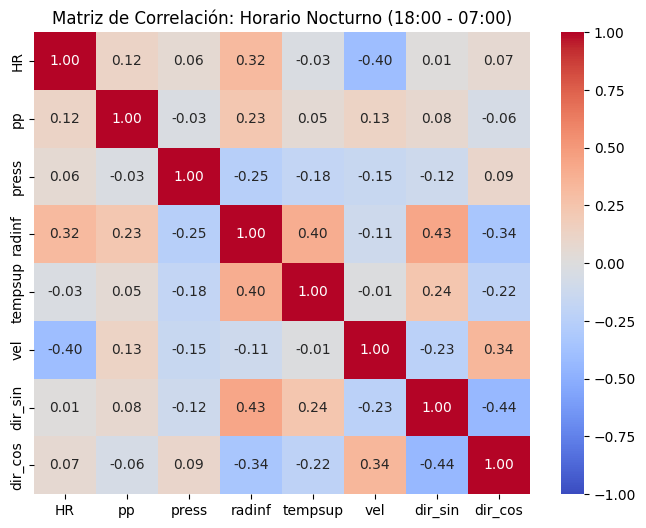

In [62]:
# 2. Nueva Matriz de Correlación (Solo Noche)
# Excluimos la columna 'dir' original (grados) para no ensuciar
cols_night = [c for c in df_night.columns if c != 'dir']
corr_night = df_night[cols_night].corr()

# 3. Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(corr_night, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de Correlación: Horario Nocturno (18:00 - 07:00)")
plt.show()

In [63]:
# 4. Ranking de influencia sobre tempsup
print("\n--- Ranking de Influencia NOCTURNA sobre Temperatura ---")
ranking = corr_night['tempsup'].sort_values(ascending=False)
print(ranking)


--- Ranking de Influencia NOCTURNA sobre Temperatura ---
tempsup    1.000000
radinf     0.397387
dir_sin    0.239092
pp         0.050418
vel       -0.014607
HR        -0.029510
press     -0.180503
dir_cos   -0.215247
Name: tempsup, dtype: float64
